In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


In [18]:


# FD001 verisini oku
train = pd.read_csv("data/train_FD001.txt", sep=" ", header=None)
train.drop(columns=[26, 27], inplace=True)  # Boş sütunları at
train.columns = ['unit', 'time'] + [f'op{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]

# Her motor için RUL hesapla
rul = train.groupby('unit')['time'].max().reset_index()
rul.columns = ['unit', 'max_time']
train = train.merge(rul, on='unit')
train['RUL'] = train['max_time'] - train['time']
train.drop('max_time', axis=1, inplace=True)

# Sensör seçimi (örnek)
sensor_cols = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8', 'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor15', 'sensor17', 'sensor20', 'sensor21']

# Normalizasyon
scaler = MinMaxScaler()
train[sensor_cols] = scaler.fit_transform(train[sensor_cols])

train.head()


,unit,time,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,0.183735,0.406802,0.309757,14.62,...,0.205882,8138.62,0.363986,0.03,0.333333,2388,100.0,0.713178,0.724662,191
1,1,2,0.0019,-0.0003,100.0,518.67,0.283133,0.453019,0.352633,14.62,...,0.279412,8131.49,0.411312,0.03,0.333333,2388,100.0,0.666667,0.731014,190
2,1,3,-0.0043,0.0003,100.0,518.67,0.343373,0.369523,0.370527,14.62,...,0.220588,8133.23,0.357445,0.03,0.166667,2388,100.0,0.627907,0.621375,189
3,1,4,0.0007,0.0000,100.0,518.67,0.343373,0.256159,0.331195,14.62,...,0.294118,8133.83,0.166603,0.03,0.333333,2388,100.0,0.573643,0.662386,188
4,1,5,-0.0019,-0.0002,100.0,518.67,0.349398,0.257467,0.404625,14.62,...,0.235294,8133.80,0.402078,0.03,0.416667,2388,100.0,0.589147,0.704502,187


In [21]:

file_path = "data/train_FD001.txt"  # Kendi dizinine göre güncelle

columns = ['unit', 'time'] + [f'op{i}' for i in range(1, 4)] + [f'sensor{i}' for i in range(1, 22)]


df = pd.read_csv(file_path, sep=r'\s+', header=None, names=columns)


# Max time for each motor
rul_max = df.groupby('unit')['time'].max().reset_index()
rul_max.columns = ['unit', 'max_time']
df = df.merge(rul_max, on='unit')
df['RUL'] = df['max_time'] - df['time']
df.drop(columns='max_time', inplace=True)

# Kullanılacak sensörleri seç (örnek olarak informative sensörler)
sensor_cols = ['sensor2', 'sensor3', 'sensor4', 'sensor7', 'sensor8',
               'sensor9', 'sensor11', 'sensor12', 'sensor13', 'sensor15',
               'sensor17', 'sensor20', 'sensor21']

# Normalize
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])


print(df.head())

   unit  time     op1     op2    op3  sensor1   sensor2   sensor3   sensor4  \
0     1     1 -0.0007 -0.0004  100.0   518.67  0.183735  0.406802  0.309757   
1     1     2  0.0019 -0.0003  100.0   518.67  0.283133  0.453019  0.352633   
2     1     3 -0.0043  0.0003  100.0   518.67  0.343373  0.369523  0.370527   
3     1     4  0.0007  0.0000  100.0   518.67  0.343373  0.256159  0.331195   
4     1     5 -0.0019 -0.0002  100.0   518.67  0.349398  0.257467  0.404625   

   sensor5  ...  sensor13  sensor14  sensor15  sensor16  sensor17  sensor18  \
0    14.62  ...  0.205882   8138.62  0.363986      0.03  0.333333      2388   
1    14.62  ...  0.279412   8131.49  0.411312      0.03  0.333333      2388   
2    14.62  ...  0.220588   8133.23  0.357445      0.03  0.166667      2388   
3    14.62  ...  0.294118   8133.83  0.166603      0.03  0.333333      2388   
4    14.62  ...  0.235294   8133.80  0.402078      0.03  0.416667      2388   

   sensor19  sensor20  sensor21  RUL  
0     100.0

In [23]:
sequence_length = 30
features = df[sensor_cols + ['unit', 'RUL']]

X, y = [], []

# Produce windows
for unit in features['unit'].unique():
    unit_df = features[features['unit'] == unit]
    unit_data = unit_df[sensor_cols].values
    unit_rul = unit_df['RUL'].values
    
    for i in range(len(unit_data) - sequence_length + 1):
        X.append(unit_data[i:i+sequence_length])
        y.append(unit_rul[i + sequence_length - 1])  # pencerenin sonundaki RUL

X = np.array(X)
y = np.array(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (17731, 30, 13), y shape: (17731,)


In [25]:


# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (14184, 30, 13), Validation shape: (3547, 30, 13)


In [27]:
# LSTM model definition
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1)  # Regression output
])

# Compile
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,417 (126.63 KB)

 Trainable params: 32,417 (126.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Callbacks 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# TRAIN
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 87.9892 - mae: 87.9892 - val_loss: 80.7069 - val_mae: 80.7069
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 80.5093 - mae: 80.5093 - val_loss: 75.1840 - val_mae: 75.1840
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 74.7640 - mae: 74.7640 - val_loss: 70.2197 - val_mae: 70.2197
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 70.2813 - mae: 70.2813 - val_loss: 66.0726 - val_mae: 66.0726
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 65.6639 - mae: 65.6639 - val_loss: 62.6473 - val_mae: 62.6473
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 63.2856 - mae: 63.2856 - val_loss: 59.8004 - val_mae: 59.8004
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 59.8895 - mae: 59.8895 - val_loss: 57.4501 - val_mae: 57.4501
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 58.0375 - mae: 58.0375 - val_loss: 55.5621 - val_mae: 55.5621
Epoch 9/50
222/2

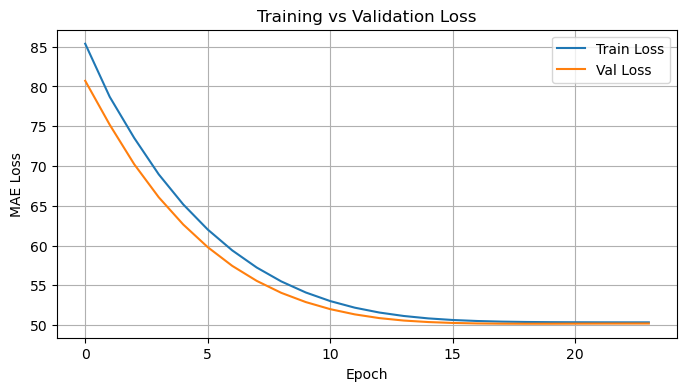

In [31]:
# Loss grafiklerini çiz
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
